# Feature engineering

## Load libraries and data

### Libraries

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np

from datetime import datetime, date, time, timedelta

import ipywidgets

import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

### Data

In [2]:
df = pd.read_csv("../data/training.csv")
df = df.drop(["CurrencyCode","CountryCode"], axis=1) # identical value across all entries
df.set_index("TransactionId", inplace=True)
df.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,
TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


## Convert TransactionStartTime to timestamps (potentially copy?)

In [3]:
# Convert string to timestamp
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], format="%Y-%m-%dT%H:%M:%SZ")

# Check if correct
duration = df['TransactionStartTime']["TransactionId_73770"] - df['TransactionStartTime']["TransactionId_76871"] # Use ID to get same result even if df is resorted
duration.seconds # Should be 19

# Sort df by date
df.sort_values(by="TransactionStartTime", inplace=True)

## Feature engineering (copy both cells below)

### Time between transactions, per categorical feature type and feature level

In [4]:
features = [ 
             #'AccountId', # Previous EDA showed poor discriminability between fraudulent and nonfraudulent for commented-out features
             #'SubscriptionId',
             #'CustomerId',
             #'ProviderId',
             'ProductId',
             'ProductCategory',
             'ChannelId',
             'PricingStrategy']

new_feature_names = list()

for i, feat in enumerate(features):
    td_feat = "TimeDelta_" + feat
    new_feature_names.append(td_feat)
    df[td_feat]  = np.zeros((len(df),1))
    df[td_feat]  = df[td_feat].apply(pd.to_timedelta)
    
    for feat_lvl in df[feat].unique().tolist():
        df_subs = df[df[feat]==feat_lvl]

        if len(df_subs)==1:
            continue
        else:
            for j in range(1,len(df_subs)):
                df[td_feat][df_subs.index[j]] = df_subs['TransactionStartTime'][j] - df_subs['TransactionStartTime'][j-1]
    
    df[td_feat] = df[td_feat].dt.seconds
    print(f"{i+1} of {len(features)} time delta features computed.")

/var/folders/53/gg42r53n4gqf4gxqzfcm5gcm0000gn/T/ipykernel_27077/1282067282.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[td_feat][df_subs.index[j]] = df_subs['TransactionStartTime'][j] - df_subs['TransactionStartTime'][j-1]


1 of 4 time delta features computed.
2 of 4 time delta features computed.
3 of 4 time delta features computed.
4 of 4 time delta features computed.


### Number of transactions, per categorical feature type and feature level

In [5]:
features = [ 
             'AccountId',
             'SubscriptionId',
             'CustomerId',
             'ProviderId',
             'ProductId',
             'ProductCategory',
             'ChannelId',
             'PricingStrategy']

new_feature_names2 = list()

for i, feat in enumerate(features):
    n_feat = "NTransactions_" + feat
    new_feature_names2.append(n_feat)
    
    df = pd.merge(df,pd.DataFrame(df.groupby(feat).count()["FraudResult"]).reset_index().rename(columns={'FraudResult': n_feat}))

## Checking the newly engineered features (no need to copy)

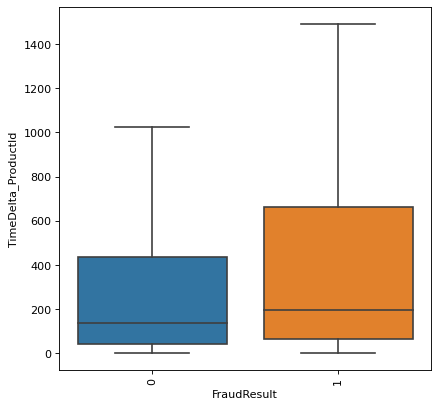

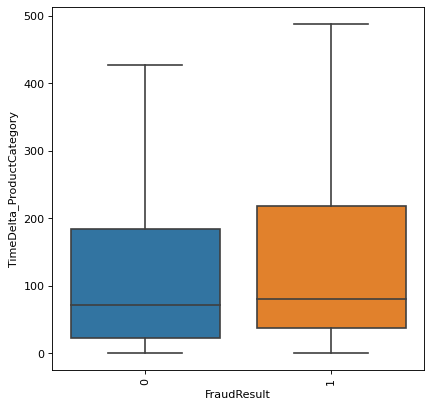

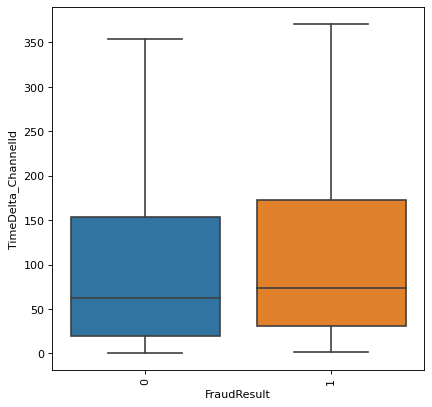

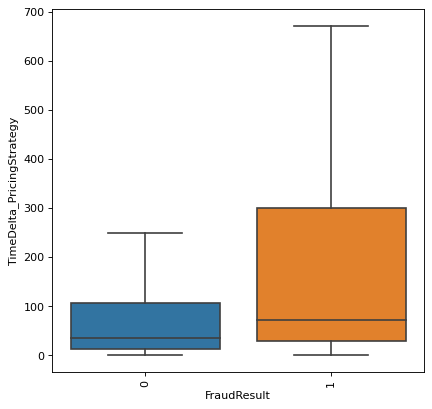

In [6]:
for feature in new_feature_names:
    plt.figure(figsize=(6,6), dpi=80)
    g = sns.boxplot(x=df["FraudResult"], y =df[feature], showfliers=False)
    plt.xticks(rotation=90)

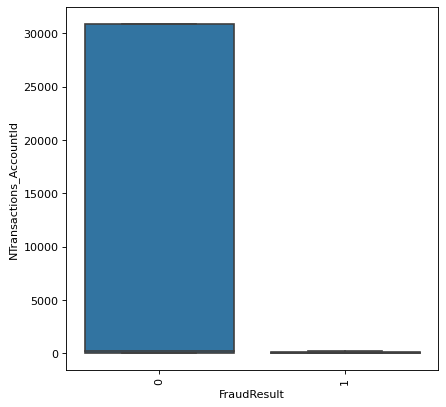

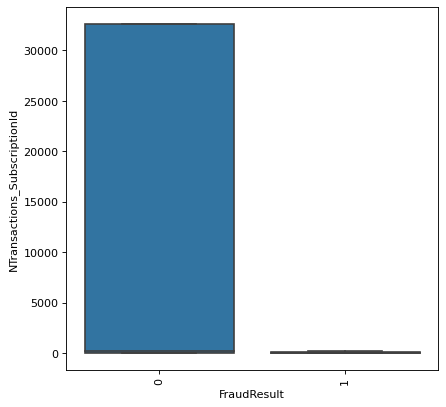

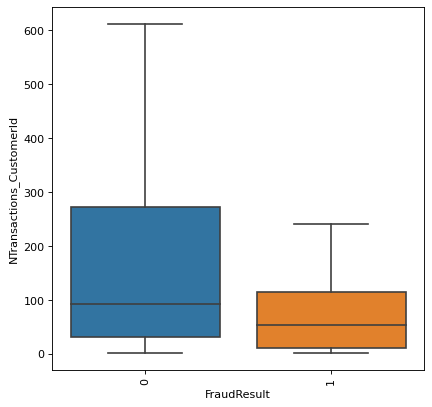

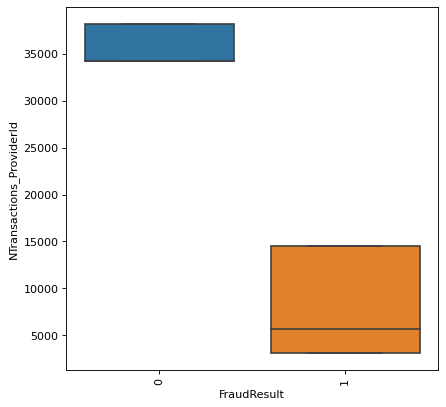

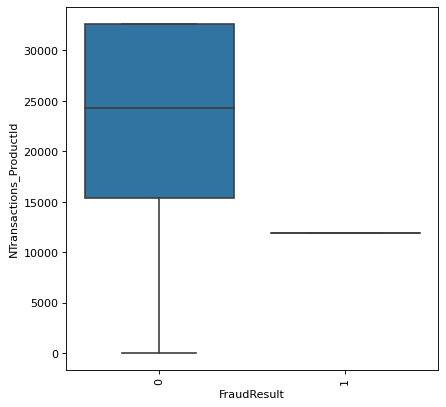

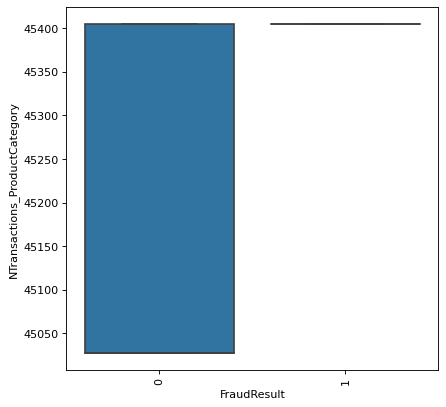

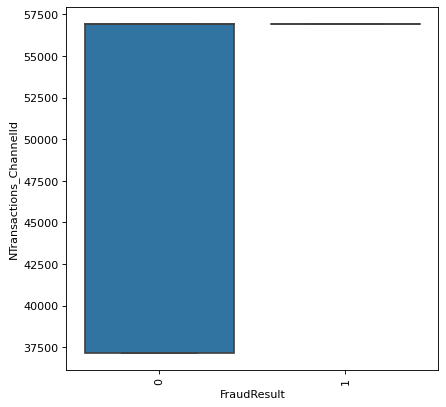

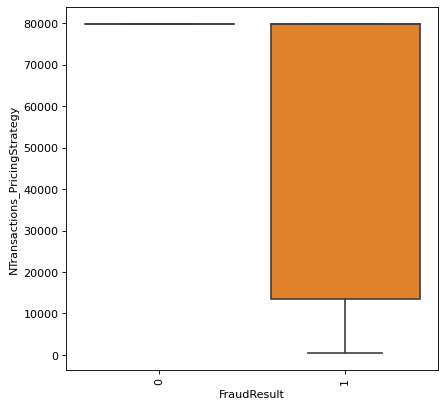

In [7]:
for feature in new_feature_names2:
    plt.figure(figsize=(6,6), dpi=80)
    g = sns.boxplot(x=df["FraudResult"], y =df[feature], showfliers=False)
    plt.xticks(rotation=90)

In [8]:
# Example: Fraudulent transactions prevalent in accounts with only one or very few transactions
df[["AccountId","NTransactions_AccountId","FraudResult"]].groupby("AccountId").mean().sort_values(by="FraudResult", ascending=False)

,NTransactions_AccountId,FraudResult
AccountId,,
AccountId_777,1.0,1.0
AccountId_1605,1.0,1.0
AccountId_1480,1.0,1.0
AccountId_3519,1.0,1.0
AccountId_3686,1.0,1.0
...,...,...
AccountId_249,5.0,0.0
AccountId_2490,1.0,0.0
AccountId_2491,14.0,0.0
